# Word2Vec and FastText


## Using Word2Vec

In [1]:
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
import multiprocessing 
from time import time 

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

TensorFlow 2.x selected.
GPU Available:  True


### PREPROCESSING

In [0]:
# set seed 
SEED = 7
random.seed(SEED)

# dataset was already cleaned
df = pd.read_csv('cleaned_dataset.csv')

In [0]:
# final cleaning
df['text'] = [bytes(x, 'utf-8').decode('utf-8', 'ignore') for x in df['text']]
df['text'] = [" ".join([re.sub(r'[^A-Za-z0-9]+', '', x) for x in i.split()]) for i in df['text']]

In [4]:
df.shape

(3133, 2)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['sentiment'], 
                                                    test_size = 0.2, 
                                                    random_state = SEED,
                                                    stratify = df['sentiment'])
y_train = y_train.values
y_test = y_test.values

In [6]:
UNIQUE_WORDS = set(" ".join([sentence for sentence in X_train]).split())
MAX_FEATURES = len(UNIQUE_WORDS)

print("Number of unique words: %d" % MAX_FEATURES)
words = [sentence.split() for sentence in X_train]

Number of unique words: 7734


#### Training Word2Vec

In [0]:
# Build Word2Vec
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count = 20,
                     window = 5,
                     size = 300,
                     sg = 1,
                     hs = 1,
                     sample = 6e-5, 
                     alpha = 0.03, 
                     min_alpha = 0.0007, 
                     workers = 1)

In [8]:
from time import time 
t = time()

w2v_model.build_vocab(words, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [9]:
t = time()

w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.06 mins


In [0]:
w2v_model.init_sims(replace=True)

In [11]:
w2v_model.wv.most_similar(positive=["siya"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('go', 0.13977129757404327),
 ('parang', 0.12514203786849976),
 ('kung', 0.12400570511817932),
 ('at', 0.11522408574819565),
 ('getgo', 0.11103355884552002),
 ('love', 0.11081290245056152),
 ('pm', 0.10024367272853851),
 ('time', 0.0999680906534195),
 ('wow', 0.09767533838748932),
 ('always', 0.09718500077724457)]

In [12]:
embeddings_index = w2v_model.wv
print(embeddings_index)

In [0]:
from tensorflow.compat.v2.keras.preprocessing.text import Tokenizer
from tensorflow.compat.v2.keras.preprocessing.sequence import pad_sequences

# Training Inputs
tokenizer = Tokenizer(num_words = MAX_FEATURES, oov_token= '<OOV>')
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
X_train_token = tokenizer.texts_to_sequences(X_train.values)
X_train_padded = pad_sequences(X_train_token, padding = 'post')

MAX_LENGTH = len(max(X_train_padded, key = len))

X_test_token = tokenizer.texts_to_sequences(X_test.values)
X_test_padded = pad_sequences(X_test_token, maxlen = MAX_LENGTH, padding = 'post')


In [14]:
print(len(word_index))

7735


In [15]:
len(X_train_padded[0]), len(X_test_padded[0])

(511, 511)

In [16]:
EMB_DIM = 300

embedding_matrix = np.zeros((MAX_FEATURES,EMB_DIM))
for word,i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    try:
        embedding_vector = embeddings_index[word]
    except:
        continue
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

embedding_matrix.shape

(7734, 300)

### MODEL

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 511, 300)          2320200   
_________________________________________________________________
bidirectional (Bidirectional (None, 392)               779296    
_________________________________________________________________
dense (Dense)                (None, 1)                 393       
Total params: 3,099,889
Trainable params: 779,689
Non-trainable params: 2,320,200
_________________________________________________________________
None


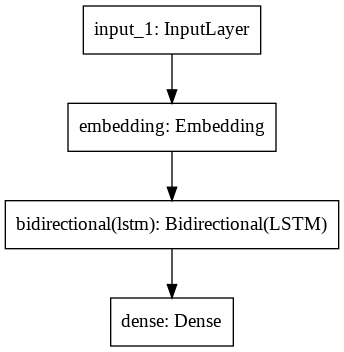

In [17]:
from tensorflow.compat.v2.keras.models import Sequential
from tensorflow.compat.v2.keras.layers import Dense, Embedding, InputLayer, LSTM, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.compat.v2.keras.optimizers import Adam, SGD
from tensorflow.compat.v2.keras import regularizers
from tensorflow.compat.v2.keras.initializers import Constant
import numpy as np
from tensorflow.compat.v2.keras.utils import plot_model
from tensorflow.compat.v2.keras.callbacks import ModelCheckpoint, EarlyStopping

model_lstm = Sequential() 
embedding_layer = Embedding(MAX_FEATURES,
                            EMB_DIM,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = MAX_LENGTH,
                            trainable = False)
inputs = InputLayer(input_shape=(MAX_LENGTH, ))
model_lstm.add(inputs)
model_lstm.add(embedding_layer)
model_lstm.add(Bidirectional(LSTM(196, dropout=0.2)))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy',
              optimizer = SGD(1e-4),    
              metrics=["accuracy"])
print(model_lstm.summary())
plot_model(model_lstm)

### TRAINING

In [18]:
BATCH_SIZE = 64
history = model_lstm.fit(X_train_padded, 
                         y_train, 
                         validation_data = (X_test_padded,y_test), 
                         batch_size = BATCH_SIZE,
                         epochs = 10)

Train on 2506 samples, validate on 627 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2506/2506 [==============================] - 18s 7ms/sample - loss: 0.6932 - accuracy: 0.5112 - val_loss: 0.6928 - val_accuracy: 0.5598
Epoch 2/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6926 - accuracy: 0.5583 - val_loss: 0.6922 - val_accuracy: 0.5726
Epoch 3/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6920 - accuracy: 0.5854 - val_loss: 0.6917 - val_accuracy: 0.5965
Epoch 4/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6916 - accuracy: 0.6125 - val_loss: 0.6911 - val_accuracy: 0.6396
Epoch 5/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6910 - accuracy: 0.6345 - val_loss: 0.6906 - val_accuracy: 0.6651
Epoch 6/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6904 - accuracy: 0.6421 - val_loss: 0.6901 

### RESULTS

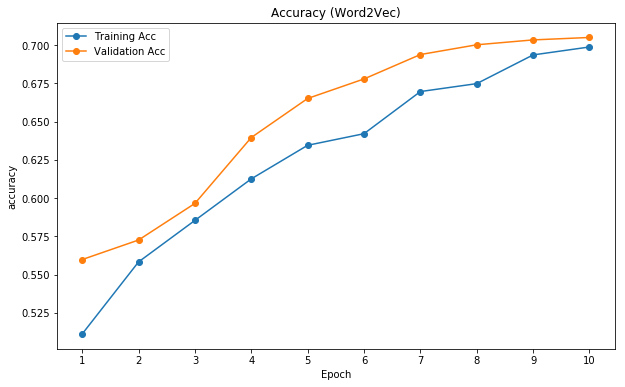

In [19]:
# visualize performance
# first training
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs = range(1, len(acc1) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, acc1, '-o', label='Training Acc')
plt.plot(epochs, val_acc1, '-o', label='Validation Acc')
plt.legend()
plt.title('Accuracy (Word2Vec)')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.xticks(epochs)
plt.savefig('accuracy_w2v.png')

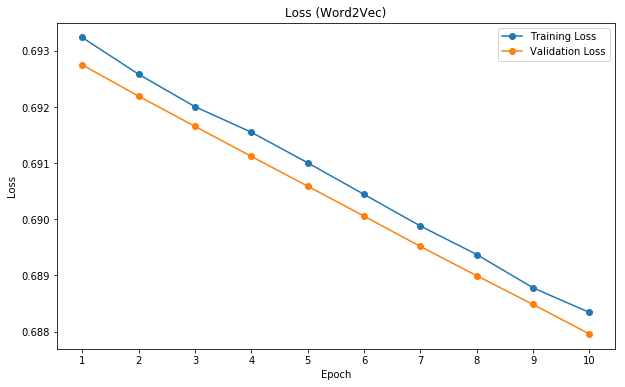

In [20]:
plt.figure(figsize=(10,6))
plt.plot(epochs, loss1, '-o', label='Training Loss')
plt.plot(epochs, val_loss1, '-o', label='Validation Loss')
plt.legend()
plt.title('Loss (Word2Vec)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.savefig('loss_w2v.png')

In [21]:
from sklearn.metrics import classification_report

pred = [int(round(x[0])) for x in model_lstm.predict(X_test_padded)]
print(classification_report(y_test, pred, digits=4))

              precision    recall  f1-score   support

           0     0.3750    0.0164    0.0314       183
           1     0.7092    0.9887    0.8260       444

    accuracy                         0.7049       627
   macro avg     0.5421    0.5026    0.4287       627
weighted avg     0.6117    0.7049    0.5941       627



## Using FastText

In [0]:
from gensim.models import FastText

In [0]:
ft_model = FastText(size = 300,
                    alpha = 0.03,
                    window = 5,
                    min_count = 20,
                    sample = 6e-5,
                    word_ngrams = 1,
                    min_n = 3, 
                    max_n = 6,
                    min_alpha = 0.0007,
                    workers = 1)

In [24]:
t = time()

ft_model.build_vocab(words, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [25]:
t = time()

ft_model.train(X_train, total_examples=ft_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.02 mins


In [0]:
ft_model.init_sims(replace = True)

In [27]:
ft_model.wv.most_similar(positive=["siya"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('niya', 0.2620971202850342),
 ('ikaw', 0.1408599615097046),
 ('si', 0.13621841371059418),
 ('old', 0.13615497946739197),
 ('promo', 0.13374973833560944),
 ('so', 0.11260346323251724),
 ('parang', 0.10820566862821579),
 ('po', 0.10181769728660583),
 ('ung', 0.10056495666503906),
 ('sir', 0.10053959488868713)]

In [0]:
embeddings_index = ft_model.wv

EMB_DIM = 300

embedding_matrix = np.zeros((MAX_FEATURES,EMB_DIM))
for word,i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    try:
        embedding_vector = embeddings_index[word]
    except:
        continue
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
len(word_index)

7735

In [30]:
embedding_matrix.shape

(7734, 300)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 511, 300)          2320200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 392)               779296    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 393       
Total params: 3,099,889
Trainable params: 779,689
Non-trainable params: 2,320,200
_________________________________________________________________
None


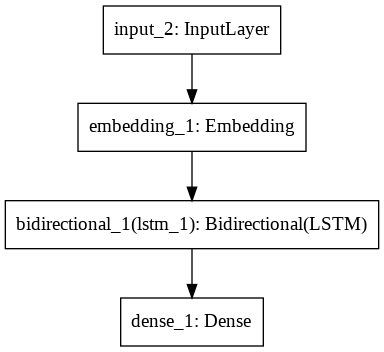

In [31]:
from tensorflow.compat.v2.keras.models import Sequential
from tensorflow.compat.v2.keras.layers import Dense, Embedding, InputLayer, LSTM, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.compat.v2.keras.optimizers import Adam, SGD
from tensorflow.compat.v2.keras import regularizers
from tensorflow.compat.v2.keras.initializers import Constant
import numpy as np
from tensorflow.compat.v2.keras.utils import plot_model
from tensorflow.compat.v2.keras.callbacks import ModelCheckpoint, EarlyStopping

model_lstm = Sequential() 
embedding_layer = Embedding(MAX_FEATURES,
                            EMB_DIM,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = MAX_LENGTH,
                            trainable = False)
inputs = InputLayer(input_shape=(MAX_LENGTH, ))
model_lstm.add(inputs)
model_lstm.add(embedding_layer)
model_lstm.add(Bidirectional(LSTM(196, dropout=0.2)))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy',
              optimizer = SGD(1e-4),    
              metrics=["accuracy"])
print(model_lstm.summary())
plot_model(model_lstm)

In [32]:
BATCH_SIZE = 64
history = model_lstm.fit(X_train_padded, 
                         y_train, 
                         validation_data = (X_test_padded,y_test), 
                         batch_size = BATCH_SIZE,
                         epochs = 10)

Train on 2506 samples, validate on 627 samples
Epoch 1/10
2506/2506 [==============================] - 17s 7ms/sample - loss: 0.6930 - accuracy: 0.5112 - val_loss: 0.6928 - val_accuracy: 0.5455
Epoch 2/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6924 - accuracy: 0.5375 - val_loss: 0.6921 - val_accuracy: 0.5901
Epoch 3/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6918 - accuracy: 0.5798 - val_loss: 0.6915 - val_accuracy: 0.6220
Epoch 4/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6912 - accuracy: 0.5946 - val_loss: 0.6909 - val_accuracy: 0.6332
Epoch 5/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6907 - accuracy: 0.6261 - val_loss: 0.6904 - val_accuracy: 0.6380
Epoch 6/10
2506/2506 [==============================] - 12s 5ms/sample - loss: 0.6900 - accuracy: 0.6524 - val_loss: 0.6898 - val_accuracy: 0.6699
Epoch 7/10
2506/2506 [==============================] - 12s 5ms/sample 

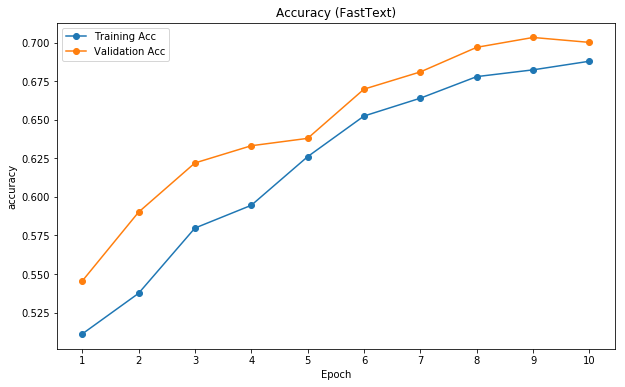

In [33]:
# visualize performance
# first training
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs = range(1, len(acc1) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, acc1, '-o', label='Training Acc')
plt.plot(epochs, val_acc1, '-o', label='Validation Acc')
plt.legend()
plt.title('Accuracy (FastText)')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.xticks(epochs)
plt.savefig('accuracy_ft.png')


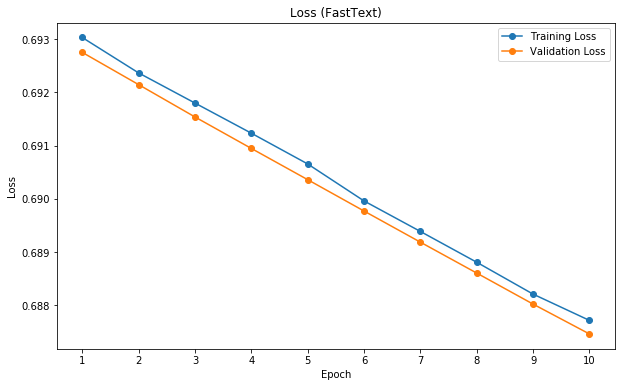

In [34]:
plt.figure(figsize=(10,6))
plt.plot(epochs, loss1, '-o', label='Training Loss')
plt.plot(epochs, val_loss1, '-o', label='Validation Loss')
plt.legend()
plt.title('Loss (FastText)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.savefig('loss_ft.png')

In [35]:
from sklearn.metrics import classification_report

pred = [int(round(x[0])) for x in model_lstm.predict(X_test_padded)]
print(classification_report(y_test, pred, digits=4))

              precision    recall  f1-score   support

           0     0.4074    0.0601    0.1048       183
           1     0.7133    0.9640    0.8199       444

    accuracy                         0.7002       627
   macro avg     0.5604    0.5120    0.4623       627
weighted avg     0.6240    0.7002    0.6112       627

